<h2>Chord Embeddings</h2>
<br>
In this notebook we will try to create chord embeddings the same way we do at NLP with Word Embeddings.<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#librosa
import librosa 

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#dimensionality reduction
from sklearn.manifold import TSNE

#embeddings
from gensim.models import Word2Vec

Create my <b>"Sentences"</b>
<hr>
1. Load chordlab files with annotations<br>
Load all bands chordlab, but the Annotations are different, so I load them seperately<br>

In [2]:
Chordlab = {'The Beatles': {}, 'Queen': {}, 'Carole King': {}, 'Zweieck': {}}

In [3]:
Band = 'The Beatles'
### get all chordlab files
for filename in Path('Big-Dataset/The Beatles').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab[Band]): 
        Chordlab[Band][album] = {}
        
    Chordlab[Band][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

In [4]:
Band = 'Queen'
### get all chordlab files
for filename in Path('Big-Dataset/Queen').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)',track).group(1)
    
    if (album not in Chordlab[Band]): 
        Chordlab[Band][album] = {}
        
    Chordlab[Band][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep='\t', header=None)

In [5]:
Band = 'Zweieck'
### get all chordlab files
for filename in Path('Big-Dataset/Zweieck').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab[Band]): 
        Chordlab[Band][album] = {}
        
    Chordlab[Band][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep='\t', header=None)

In [6]:
Band = 'Carole King'
### get all chordlab files
for filename in Path('Big-Dataset/Carole King').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)',track).group(1)
    
    if (album not in Chordlab[Band]): 
        Chordlab[Band][album] = {}
    
    Chordlab[Band][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep='\t', header=None)

2. Transform annotations to chord progressions - or else sentences.<br>

In [11]:
# delete inversion tool for accuracy
def delete_inversion(chord):
    if chord.find('/') != -1:
        chord, _ = chord.split('/')
    return chord

In [12]:
Chord_Progressions = []
for band in Chordlab.keys():
    for album in Chordlab[band].keys():
        for track_no in Chordlab[band][album].keys():
            progression = []
            for index, row in Chordlab[band][album][track_no].iterrows():
                # filter out silences (N)
                chord = delete_inversion(row['Chord'])
                if (chord != 'N'):
                    progression.append(chord)
            Chord_Progressions.append(progression)

<b>Vocabulary</b>

In [13]:
### Load all chords in a dictionary
Chords = []
for band in Chordlab.keys():
    for album in Chordlab[band].keys():
        for track_no in Chordlab[band][album].keys():
            for index, row in Chordlab[band][album][track_no].iterrows():
                chord = delete_inversion(row['Chord'])
                if chord not in Chords: 
                    Chords.append(chord)
### How many chords do we have in our dataset?
vocab_size = len(Chords)
print ("Vocab Size: ",vocab_size)

Vocab Size:  321


<h3>Train chord embeddings by progressions</h3>
<br>
Let's build some Chord embeddings, just by looking at chord progressions as text, without looking at any notes or harmony beneath.<br>


In [32]:
# easy embeddings with gensim
model = Word2Vec(Chord_Progressions, size=200, window=4, min_count=1, negative=5, workers=4)

model.train(Chord_Progressions, total_examples=len(Chord_Progressions), epochs=3)

model.wv.most_similar(positive=['C','G', 'A:min', 'F:maj7'], topn=407)

[('G:maj(*1)', 0.9852423667907715),
 ('A:min7', 0.9762066006660461),
 ('G:7', 0.9511075019836426),
 ('D:7', 0.9479802250862122),
 ('F:maj(9)', 0.947295069694519),
 ('E:min7', 0.9404309391975403),
 ('E:min', 0.9292876720428467),
 ('E:7(b9)', 0.9145159721374512),
 ('D:sus4', 0.9140965938568115),
 ('D:min', 0.9080585241317749),
 ('F', 0.8977642059326172),
 ('C:7', 0.8699357509613037),
 ('C:maj6', 0.8573770523071289),
 ('D#', 0.8521050214767456),
 ('D:min7(4)', 0.8487164378166199),
 ('F:maj6', 0.8425965905189514),
 ('D:9(11)', 0.8370676636695862),
 ('G:9', 0.8367611169815063),
 ('D:7(#9)', 0.8352525234222412),
 ('F:maj9(*7)', 0.8264195919036865),
 ('E:min6', 0.8182194828987122),
 ('C:maj7', 0.816633403301239),
 ('D:sus4(b7)', 0.8151559829711914),
 ('B:min7', 0.7999421954154968),
 ('D:min7', 0.7951653599739075),
 ('C:maj(2)', 0.7916216254234314),
 ('C:maj(4)', 0.7878305315971375),
 ('D:6', 0.7869158983230591),
 ('A:sus4(b7)', 0.7865722179412842),
 ('D:sus4(9)', 0.785321831703186),
 ('G:9(*3

<b>Results: </b>As we can see, it responded quite well. All those good results, are chords that are seen before-after <b>F</b> -> Dmin always appears on top, which is the relative minor of F.
<br>
Now, let's plot the chords vectors with <b>TSNE for dimensionality reduction</b><br>

In [15]:
def tsne_plot(model, w2v):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word, val in model:
        tokens.append(w2v.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15,6)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


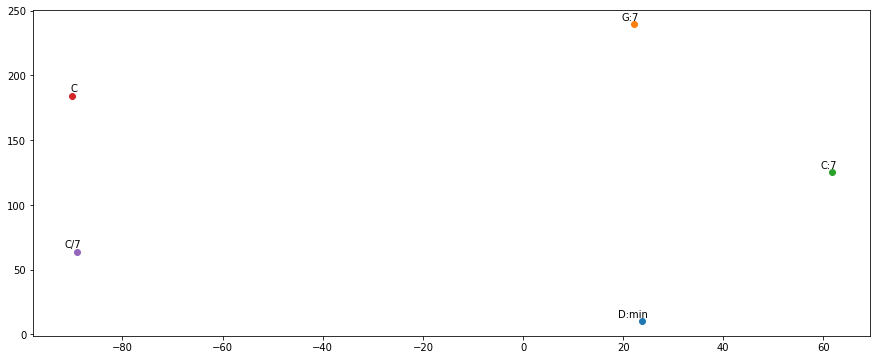

In [16]:
#plot
tsne_plot(model.wv.most_similar(positive='F', topn = 5), model)

<h3>Chord Embeddings with Notes</h3>